# Self-Driving Car Engineer Nanodegree

## Deep Learning: Build a Traffic Sign Recognition Classifier


In this notebook, a CNN is trained with German Traffic Signs Dataset to create a classifier that can distinguish a random traffic sign picture. 

---
## Step 0: Load The Data

#### Dependency

In [78]:
import pickle
import csv
import matplotlib.pyplot as plt
import random
import skimage as sk
from skimage import transform
from skimage import util
from skimage.transform import resize
import numpy as np
from scipy import ndarray
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten
import tensorflow as tf
import scipy.ndimage as im

In [79]:
training_file = './traffic-signs-data/train.p'
validation_file= './traffic-signs-data/valid.p'
testing_file = './traffic-signs-data/test.p'
label_file = './traffic-signs-data/signnames.csv'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
with open(label_file) as csvfile:
    reader = csv.reader(csvfile, delimiter=' ')
    labels = {''.join(row).split(',')[0]:''.join(row).split(',')[1] for row in reader}
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [80]:
n_train = X_train.shape[0]
n_valid = X_valid.shape[0]
n_test = X_test.shape[0]
image_shape = X_train[0].shape
n_classes = len(labels) - 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)



Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

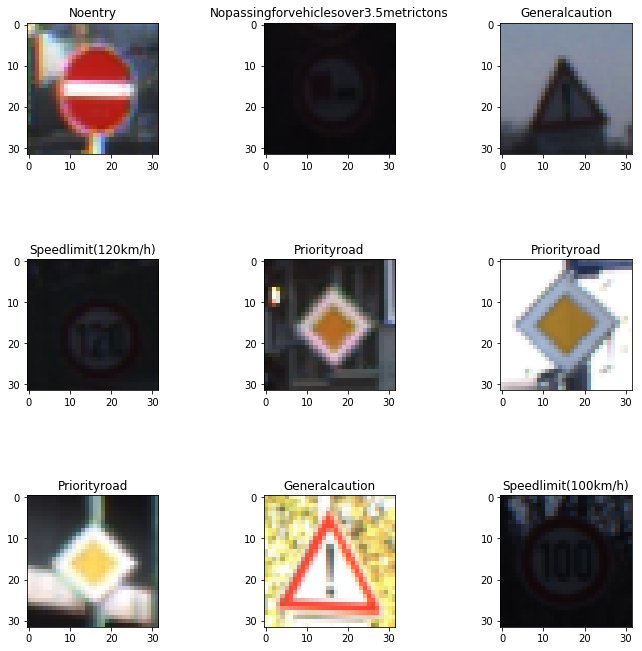

In [81]:
# Visualizations the dataset.
%matplotlib inline

def plot_random_from_dataset(pictures, classes, labels, columns=3, rows=3):
    fig=plt.figure(figsize=(12, 12))
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        index = random.randint(0,n_train)
        plt.imshow(pictures[index])
        plt.title(labels[str(classes[index])])
    plt.subplots_adjust(left=0.2, wspace=0.8, top=0.9)
    plt.show()

plot_random_from_dataset(X_train, y_train, labels)


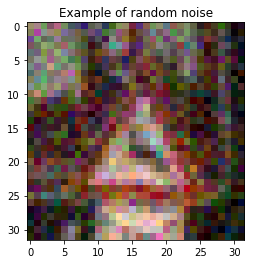

In [82]:
plt.imshow(sk.util.random_noise(X_train[757]))
plt.title('Example of random noise')

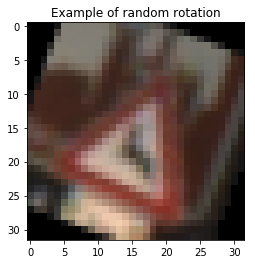

In [83]:
plt.title('Example of random rotation')
plt.imshow(sk.transform.rotate(X_train[757], random.uniform(-25, 25)))

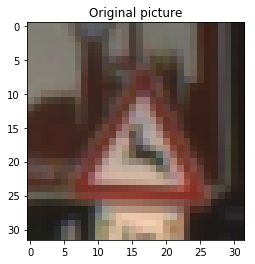

In [84]:
plt.title('Original picture')
plt.imshow(X_train[757])

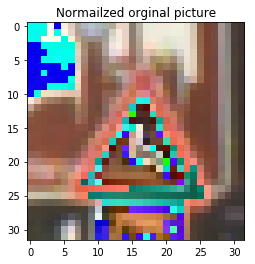

In [85]:
def normalize(x):
    return (x.astype(float) - 128) / 128
plt.title('Normailzed orginal picture')
plt.imshow(normalize(X_train[757]))

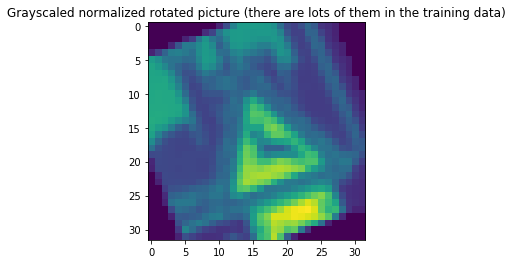

In [86]:
def rgb2gray(rgb_images):
    return np.dot(rgb_images[...,:3], [0.299, 0.587, 0.114])
plt.title('Grayscaled normalized rotated picture (there are lots of them in the training data)')
plt.imshow(rgb2gray(normalize(sk.transform.rotate(X_train[757], random.uniform(-25, 25)))))

Average number of samples:  809.2790697674419
count:  [ 180. 1980. 2010. 1260. 1770. 1650.  360. 1290. 1260. 1320. 1800. 1170.
 1890. 1920.  690.  540.  360.  990. 1080.  180.  300.  270.  330.  450.
  240. 1350.  540.  210.  480.  240.  390.  690.  210.  599.  360. 1080.
  330.  180. 1860.  270.  300.  210.  210.]
need:  [1830.   30.    0.  750.  240.  360. 1650.  720.  750.  690.  210.  840.
  120.   90. 1320. 1470. 1650. 1020.  930. 1830. 1710. 1740. 1680. 1560.
 1770.  660. 1470. 1800. 1530. 1770. 1620. 1320. 1800. 1411. 1650.  930.
 1680. 1830.  150. 1740. 1710. 1800. 1800.]


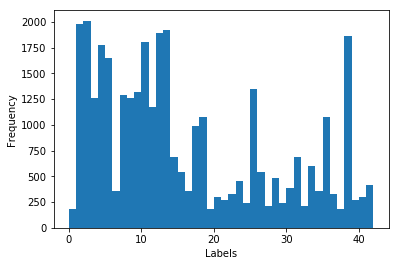

In [87]:
counting = np.zeros(n_classes)
label_to_sample = {}
index=0
for label in y_train:
    counting[label] += 1
    if not label in label_to_sample:
        label_to_sample[label] = np.zeros(0)
    label_to_sample[label] = np.append(label_to_sample[label], index)
    index +=1

print('Average number of samples: ',np.mean(counting))
print('count: ',counting)
plt.xlabel("Labels")
plt.ylabel("Frequency")
_ = plt.hist(y_train, bins=range(0, n_classes))
# Some has too many, but some has too few
need_to_augment = np.max(counting) - counting
print('need: ',need_to_augment)

41 done ,added 1800.0
31 done ,added 1320.0
36 done ,added 1680.0
26 done ,added 1470.0
23 done ,added 1560.0
1 done ,added 30.0
40 done ,added 1710.0
22 done ,added 1680.0
37 done ,added 1830.0
16 done ,added 1650.0
3 done ,added 750.0
19 done ,added 1830.0
4 done ,added 240.0
11 done ,added 840.0
42 done ,added 1800.0
0 done ,added 1830.0
32 done ,added 1800.0
27 done ,added 1800.0
29 done ,added 1770.0
24 done ,added 1770.0
9 done ,added 690.0
5 done ,added 360.0
38 done ,added 150.0
8 done ,added 750.0
10 done ,added 210.0
35 done ,added 930.0
34 done ,added 1650.0
18 done ,added 930.0
6 done ,added 1650.0
13 done ,added 90.0
7 done ,added 720.0
30 done ,added 1620.0
39 done ,added 1740.0
21 done ,added 1740.0
20 done ,added 1710.0
33 done ,added 1411.0
28 done ,added 1530.0
12 done ,added 120.0
14 done ,added 1320.0
15 done ,added 1470.0
17 done ,added 1020.0
2 done ,added 0.0
25 done ,added 660.0
(86472, 32, 32, 3)
(86472,)


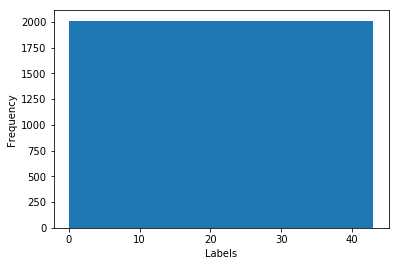

In [88]:
def random_rotation(image_array: ndarray):
    # pick a random degree of rotation between 25% on the left and 25% on the right
    random_degree = random.uniform(-25, 25)
    return sk.transform.rotate(image_array, random_degree)

def random_noise(image_array: ndarray):
    # add random noise to the image
    return sk.util.random_noise(image_array)

# After some experimenting, just apply noise and rotation wouldn't increase the accuracy
# instead the accuracy sightly decreased. After counting the distribution of the data, I found
# some labels have too few data and some have too many. Just making more data overall would exacerbate
# the situation. Making more fake data on those with too few would be a better strategy. 

# Make the distribution even
for label, indexes in label_to_sample.items():
    need = need_to_augment[label]
    while need > 0 :
        X_temp = []
        for index in shuffle(indexes):
            X_temp.append(random_rotation(X_train[int(index)]))
            y_train = np.append(y_train, label)
            need -= 1
            if need < 0:
                break
        X_train = np.concatenate((X_train, np.asarray(X_temp)), axis=0)
    print(label, 'done', ',added', need_to_augment[label])
print(X_train.shape)
print(y_train.shape)


# Plot it
plt.xlabel("Labels")
plt.ylabel("Frequency")
_ = plt.hist(y_train, bins=range(0, n_classes+1))

In [89]:
NUMBER_OF_NOISE_ITER = 2
NUMBER_OF_ROT_ITER = 2
# X_train, y_train = add_data(X_train, y_train, NUMBER_OF_ROT_ITER, random_rotation) # Generate random rotation images
# X_train, y_train = add_data(X_train, y_train, NUMBER_OF_NOISE_ITER, random_noise) # Generate random noise images
    

print('New X_train shape:', X_train.shape)
print('New y_train shape:', y_train.shape)
n_train = X_train.shape[0] # Update the n_train 

New X_train shape: (86472, 32, 32, 3)
New y_train shape: (86472,)


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

In [90]:
def normalize(x):
    return (x.astype(float) - 128) / 128

# Hard coded formula Y' = 0.299 R + 0.587 G + 0.114 B 
def rgb2gray(rgb_images):
    return np.dot(rgb_images[...,:3], [0.299, 0.587, 0.114])

The data is normailzed first. 

Examples of image after normalization: 


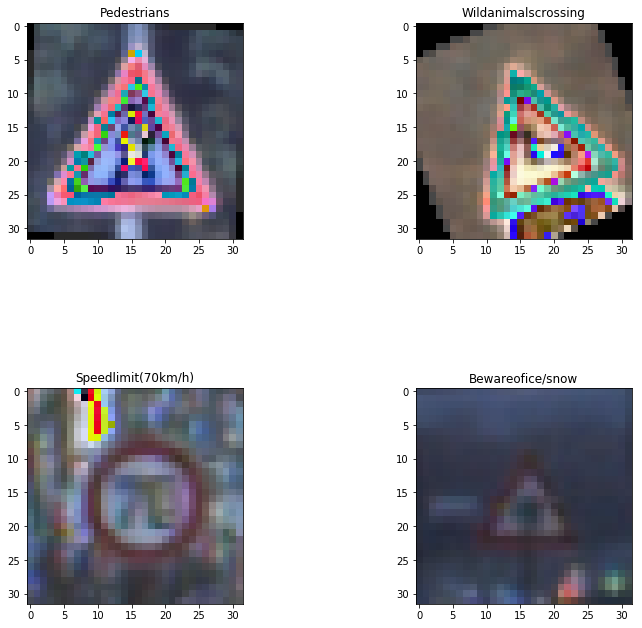

In [91]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

X_train = normalize(X_train)
X_valid = normalize(X_valid)
X_test = normalize(X_test)
print('Examples of image after normalization: ')
plot_random_from_dataset(X_train, y_train, labels, 2, 2)


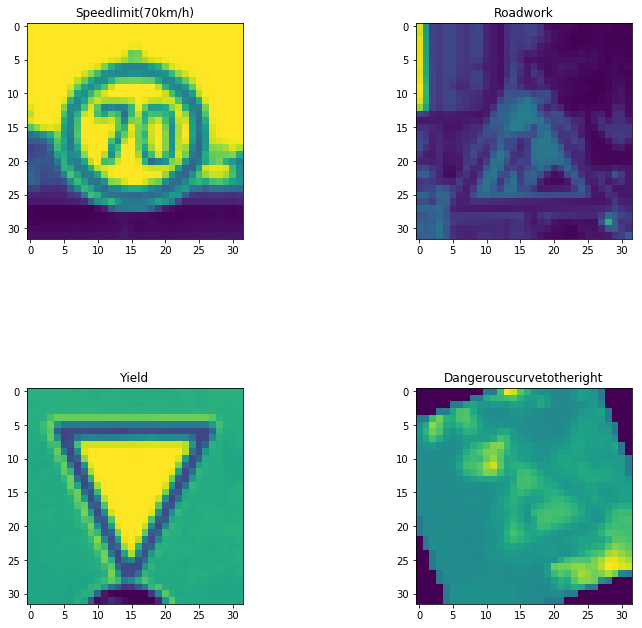

(86472, 32, 32, 1)


In [92]:
X_train = rgb2gray(X_train)
X_valid = rgb2gray(X_valid)
X_test = rgb2gray(X_test)
plot_random_from_dataset(X_train, y_train, labels, 2, 2)
X_train = X_train.reshape(n_train, image_shape[0], image_shape[1], 1)
X_valid = X_valid.reshape(n_valid, image_shape[0], image_shape[1], 1)
X_test = X_test.reshape(n_test, image_shape[0], image_shape[1], 1)
print(X_train.shape)

### Model Architecture

In [93]:
EPOCHS = 30
BATCH_SIZE = 128

# End up didn't use this becuase it failed to give a better result than
# plane old hard coded gray scale conversion
def gray_scale_layer(x, mu = 0, sigma = 0.1):
    # Input = 32x32x3. Output = 32x32x1.
    conv_W = tf.Variable(tf.truncated_normal(shape=(1, 1, 3, 1), mean = mu, stddev = sigma))
    conv_b = tf.Variable(tf.zeros(1))
    conv   = tf.nn.conv2d(x, conv_W, strides=[1, 1, 1, 1], padding='VALID') + conv_b
    return conv

# LeNet with changable number of image channels and number of output classes
# After experimenting, convert to gray scale is better than using RGB
def LeNet(x, number_of_image_channels, number_of_classes):    
    print('number_of_image_channels:', number_of_image_channels)
    print('number_of_classes:', number_of_classes)
    # Arguments used for tf.truncated_normal, 
    # randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    L1_FEATURES = 26
    
    # Layer 1: Convolutional. Input = 32x32x(number_of_image_channels). Output = 28x28xL1_FEATURES.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, number_of_image_channels, L1_FEATURES), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(L1_FEATURES))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28xL1_FEATURES. Output = 14x14xL1_FEATURES.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    L2_FEATURES = 36
    
    # Layer 2: Convolutional. Output = 10x10xL2_FEATURES.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, L1_FEATURES, L2_FEATURES), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(L2_FEATURES))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10xL2_FEATURES. Output = 5x5xL2_FEATURES.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    L3_FEATURES = 200
    
    # Layer 3: Fully Connected. Input = 400. Output = L3_FEATURES.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(5 * 5 * L2_FEATURES, L3_FEATURES), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(L3_FEATURES))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = L3_FEATURES. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(L3_FEATURES, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = number_of_classes.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, number_of_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(number_of_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

#### Prepare placeholder

In [94]:
channels = X_train.shape[3]
x = tf.placeholder(tf.float32, (None, 32, 32, channels))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

#### Training Pipeline

In [95]:
rate = 0.001

logits = LeNet(x, 1, n_classes)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

number_of_image_channels: 1
number_of_classes: 43


#### Model Evaluation

In [96]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

#### Train the Model!

In [98]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, n_train, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.873

EPOCH 2 ...
Validation Accuracy = 0.913

EPOCH 3 ...
Validation Accuracy = 0.929

EPOCH 4 ...
Validation Accuracy = 0.931

EPOCH 5 ...
Validation Accuracy = 0.937

EPOCH 6 ...
Validation Accuracy = 0.933

EPOCH 7 ...
Validation Accuracy = 0.944

EPOCH 8 ...
Validation Accuracy = 0.907

EPOCH 9 ...
Validation Accuracy = 0.950

EPOCH 10 ...
Validation Accuracy = 0.950

EPOCH 11 ...
Validation Accuracy = 0.953

EPOCH 12 ...
Validation Accuracy = 0.944

EPOCH 13 ...
Validation Accuracy = 0.944

EPOCH 14 ...
Validation Accuracy = 0.956

EPOCH 15 ...
Validation Accuracy = 0.953

EPOCH 16 ...
Validation Accuracy = 0.954

EPOCH 17 ...
Validation Accuracy = 0.944

EPOCH 18 ...
Validation Accuracy = 0.959

EPOCH 19 ...
Validation Accuracy = 0.959

EPOCH 20 ...
Validation Accuracy = 0.960

EPOCH 21 ...
Validation Accuracy = 0.966

EPOCH 22 ...
Validation Accuracy = 0.954

EPOCH 23 ...
Validation Accuracy = 0.967

EPOCH 24 ...
Validation Accura

#### Evaluate the Model

In [99]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from .\lenet
Test Accuracy = 0.938


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

C:\Users\rozoa\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


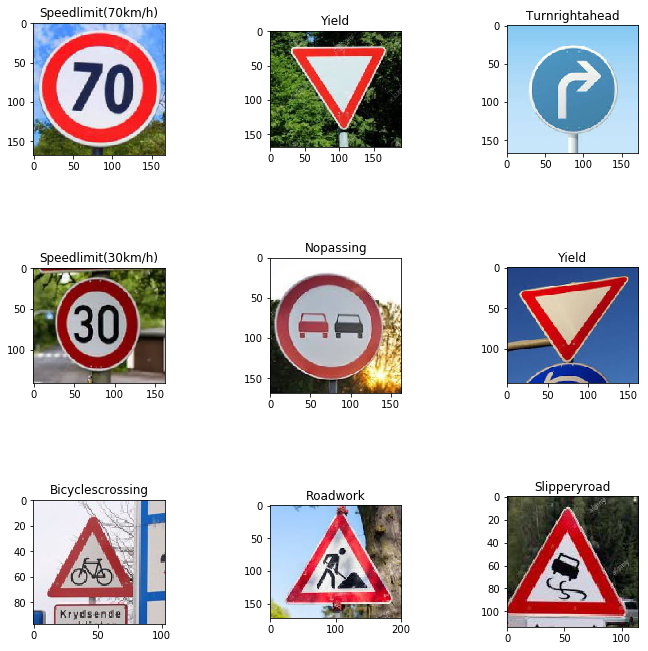

Imgs shape after formatted (9, 32, 32, 1)


In [100]:
img_array = []
net_img_labels = [4,13,33,1,9,13,29,25,23]
fig=plt.figure(figsize=(12, 12))
for i in range(1, 10):
    fig.add_subplot(3, 3, i)
    new_img = im.imread('./traffic-signs-data/' + str(i) + '.JPG')
    plt.imshow(new_img)
    plt.title(labels[str(net_img_labels[i-1])])
    img_array.append(np.array(transform.resize(rgb2gray(normalize(new_img)), (32, 32))))
    # plt.title(labels[str(classes[index])])
plt.subplots_adjust(left=0.2, wspace=0.8, top=0.9)
plt.show()
img_array = np.array(img_array).reshape(9, 32, 32, 1)
print('Imgs shape after formatted',img_array.shape)

### Predict the Sign Type for Each Image

In [101]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    prediction = tf.argmax(logits, 1)
    prediction_result = sess.run(prediction, feed_dict={x: img_array})
    print('The pictures classes are', prediction_result)
    label_results = list(map(lambda cls: labels[str(cls)], prediction_result))
    print('The pictures are', label_results)

INFO:tensorflow:Restoring parameters from .\lenet
The pictures classes are [ 4 13 33  1  9 13 24 25 23]
The pictures are ['Speedlimit(70km/h)', 'Yield', 'Turnrightahead', 'Speedlimit(30km/h)', 'Nopassing', 'Yield', 'Roadnarrowsontheright', 'Roadwork', 'Slipperyroad']


### Analyze Performance

In [102]:
correct_count = 0
for i in range(0, len(net_img_labels)):
    if(prediction_result[i] == net_img_labels[i]):
        correct_count += 1
print('Accuracy is', round(correct_count/len(net_img_labels), 4) * 100, '%')

Accuracy is 88.89 %


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")